# Non-Transformed Temporal Similarity Search

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

Non-Transformed TSS enables near real-time analysis directly upon time series windows without the overhead of extracting and embedding vectors or building a search index. 

This feature leads to optimized processing of fast flowing time series datasets without any model dependency. It offers dynamic search capability allowing the identification of patterns and outliers within temporal windows using query vectors of different sized sequences - including accepting multiple query vectors of differing sizes at once. 

Agenda:

1. Dependencies, Imports & Setup
2. Define KDB.AI Session
3. Generate Synthetic Market Time Series Data
4. Create KDB.AI Schema & Table
5. Insert Data into KDB.AI Table
6. Run Non-Transformed Temporal Similarity Search
   - Similarity Search
   - Outlier Search
   - Dynamic Search
   - Multiple Search
7. Search Evaluation 
8. Drop the Table

### 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install kdbai_client

In [ ]:
### !!! Only run this cell if running the notebook in Colab
### This downloads sample market data into Colab
!mkdir ./data 
!wget -P ./data https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/TSS_non_transformed/data/marketTrades.parquet

In [1]:
# KX Dependencies
import kdbai_client as kdbai
# Other Dependencies
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from getpass import getpass
import time

In [2]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Dependencies for metric gathering
import psutil
import datetime

# Report memory usage of Python + KDB.AI
def get_memory_usage():
    virtual_memory = psutil.virtual_memory()
    return virtual_memory.used / (1024 ** 2)  # Memory usage in megabytes

## 2. Define KDB.AI Session
KDB.AI comes in two offerings:

KDB.AI Cloud - For experimenting with smaller generative AI projects with a vector database in our cloud.
KDB.AI Server - For evaluating large scale generative AI applications on-premises or on your own cloud provider.
Depending on which you use there will be different setup steps and connection details required.

Option 1. KDB.AI Cloud
To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free here.

You can connect to a KDB.AI Cloud session using kdbai.Session and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables KDBAI_ENDPOINTS and KDBAI_API_KEY exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect. If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

### Option 1. KDB.AI Cloud

In [ ]:
#Set up KDB.AI endpoing and API key
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [ ]:
### Start Session with KDB.AI Cloud
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Option 2. KDB.AI Server
To use KDB.AI Server, you will need download and run your own container. To do this, you will first need to sign up for free [here](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html).

You will receive an email with the required license file and bearer token needed to download your instance. Follow instructions in the signup email to get your session up and running.

Once the setup steps are complete you can then connect to your KDB.AI Server session using kdbai.Session and passing your local endpoint.

In [4]:
session = kdbai.Session()

## 3. Load Synthetic Market Time Series Data
We have pre-generated 50,000 data points for example stocks 'AAA' and 'BBB' in a parquet file called `marketTrades.parquet`. Let's load these to a dataframe where:

- time: When the trade took place
- sym: The symbol of the stock being traded
- qty: The quantity of stock traded
- price: The price of the stock being traded

In [71]:
df = pd.read_parquet('data/marketTrades.parquet')
df

,index,time,sym,qty,price
0,0,2024-02-19 00:00:23.408442735,AAA,8000,25.198061
1,1,2024-02-19 00:00:50.002746284,AAA,2000,25.589870
2,2,2024-02-19 00:01:13.951318860,AAA,4000,25.435139
3,3,2024-02-19 00:01:21.386703997,AAA,1000,25.378082
4,4,2024-02-19 00:01:48.257409185,AAA,8000,25.830731
...,...,...,...,...,...
49995,49995,2024-03-04 23:56:43.126595914,BBB,3000,17.611573
49996,49996,2024-03-04 23:56:49.295240789,BBB,3000,17.652760
49997,49997,2024-03-04 23:57:06.397743076,BBB,1000,17.215983
49998,49998,2024-03-04 23:59:19.743730723,BBB,10000,17.096576


## 4. Create KDB.AI Schema & Table

In [72]:
# First ensure the table does not already exist
if 'trade_tss' in session.list():
    table = session.table('trade_tss')
    table.drop()

In [73]:
# Define the schema with similar columns to the dataframe. The price column is where the time series vectors will be inserted
# The vectorIndex type in the price column uses type 'tss', which represents Non-Transformed Temporal Similarity Search
schema = dict(
    columns=[
        dict(
            name='index', 
            pytype='int64'
            ),        
        dict(
            name='time', 
            pytype='datetime64[ns]'
            ),
        dict(
            name='sym', 
            pytype='str'
            ),
        dict(
            name='qty', 
            pytype='int64'
            ),
        dict(
            name='price', 
            pytype='float64',
            vectorIndex=
                dict(
                    type='tss', 
                    metric='L2'
                    )
            )
        ]
    )

In [74]:
#Create the table called "trade_tss"
table = session.create_table('trade_tss', schema)

## 5. Insert Data into KDB.AI Table

In [76]:
table.insert(df)

True

## 6. Run Non-Transformed Temporal Similarity Search

#### Create Raw Windows for Query String
Now, we create a new DataFrame where each row represents a sliding window of size D = 1000 data points over the original dataframe, grouped by symbol.
We take the hundredth vector and use that as our search vector

In [78]:
# Create raw windows
D = 1000 # Sliding Window Size
vecdf = df.groupby(['sym']).apply(
    lambda x: pd.DataFrame({
        'time': sliding_window_view(x['time'], D)[:, 0],  # Adjusted to keep the last time in the window
        'sym': x['sym'].iloc[0],
        'price': list(sliding_window_view(x['price'], D))
    })
).reset_index(drop=True).reset_index()
memory_vecdf_created=get_memory_usage()

In [79]:
q = vecdf['price'][100].tolist()

In [80]:
vecdf.head()

,index,time,sym,price
0,0,2024-02-19 00:00:23.408442735,AAA,"[25.1980605549179, 25.58986971201375, 25.43513..."
1,1,2024-02-19 00:00:50.002746284,AAA,"[25.58986971201375, 25.43513912591152, 25.3780..."
2,2,2024-02-19 00:01:13.951318860,AAA,"[25.43513912591152, 25.37808242137544, 25.8307..."
3,3,2024-02-19 00:01:21.386703997,AAA,"[25.37808242137544, 25.830730823799968, 25.607..."
4,4,2024-02-19 00:01:48.257409185,AAA,"[25.830730823799968, 25.607446282170713, 26.07..."


Text(0.5, 1.0, 'Query Vector')

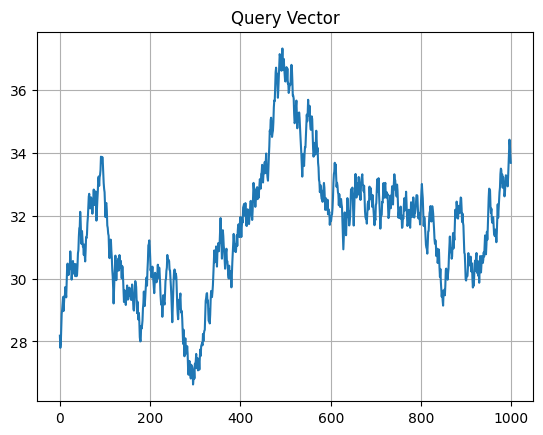

In [81]:
plt.plot(q) # See what the search vector looks like
plt.grid(True)
plt.title('Query Vector')

### Similarity Search
Run similarity search using our query vector q, and returning the top 10 most similar matches. We also collect some stats on the search for later analysis

In [82]:
sim_start=datetime.datetime.now()
res = table.search(vectors=[q], n=10)[0]
sim_stop=datetime.datetime.now()
memory_sim_post_search=get_memory_usage()
res

,index,time,sym,qty,price,__nn_distance
0,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,0.000013
1,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,4.527070
2,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,4.532988
3,98,2024-02-19 01:19:35.593288242,AAA,9000,28.493217,6.594388
4,102,2024-02-19 01:24:08.510938882,AAA,7000,27.933083,6.612245
5,97,2024-02-19 01:19:32.584855556,AAA,6000,28.734376,7.984468
6,103,2024-02-19 01:24:39.233463853,AAA,9000,28.403252,8.011267
7,96,2024-02-19 01:19:27.989527434,AAA,1000,28.989396,9.142472
8,104,2024-02-19 01:26:20.481255054,AAA,9000,28.880188,9.172721
9,95,2024-02-19 01:19:09.146237969,AAA,7000,29.201223,10.124061


As expected, our 100th vector, which is identical to the query vector 'q', was returned as the top result. We also see that the vectors surrounding the 100th vector are also returned, which is expected as they will also contain large segments similar to the query vector.

### Outlier Search
Another feature of Non-Transformed Temporal Similarity Search is the ability to do outlier search. This will return the most dissimilar vectors.

To do this, we run a search with n equal to the negative of the number of most dissimilar results we want returned, for example n = -10.

In [83]:
out_start=datetime.datetime.now()
res = table.search(vectors=[q], n=-10)[0]
out_stop=datetime.datetime.now()
memory_out_windows_post_search=get_memory_usage()
res

,index,time,sym,qty,price,__nn_distance
0,13075,2024-02-26 20:34:19.050180763,AAA,4000,59.715426,59.125275
1,13074,2024-02-26 20:33:45.411256402,AAA,2000,59.351530,59.114667
2,13076,2024-02-26 20:34:52.536420375,AAA,5000,59.826193,59.111672
3,13073,2024-02-26 20:33:17.896016389,AAA,5000,59.138623,59.107935
4,13077,2024-02-26 20:35:33.751646429,AAA,10000,60.131198,59.097348
5,13072,2024-02-26 20:32:59.920857399,AAA,4000,58.847480,59.091311
6,13078,2024-02-26 20:39:03.432464450,AAA,9000,59.749958,59.074251
7,13071,2024-02-26 20:32:00.419369638,AAA,4000,59.093172,59.071500
8,13070,2024-02-26 20:30:26.397550106,AAA,9000,58.770047,59.057446
9,13079,2024-02-26 20:39:26.932638734,AAA,1000,60.111276,59.056613


### Dynamic Search
A strengh of Non-Transformed Temporal Similarity Search is the ability to change the size (number of data points) of the query vector between searches.
This means we do not need to create new embeddings to search over different window sizes.

In this example, our query vector is reduced to 50 data points from the original 1000 data point query vector:

In [84]:
smaller_query_50=q[:-950]
print("Query elements: ", len(smaller_query_50))
table.search(vectors=[smaller_query_50], n=10)[0]

Query elements:  50


,index,time,sym,qty,price,__nn_distance
0,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,0.000000
1,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,2.060435
2,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,2.140956
3,14907,2024-02-27 23:18:12.271115630,AAA,9000,58.904305,2.369705
4,27249,2024-02-20 07:46:35.792305469,BBB,6000,15.817259,2.375721
5,14906,2024-02-27 23:17:01.033421158,AAA,9000,59.331964,2.385418
6,42517,2024-02-29 10:50:59.415277093,BBB,6000,10.757307,2.388048
7,27250,2024-02-20 07:48:04.330449253,BBB,9000,15.494382,2.431020
8,14905,2024-02-27 23:14:51.579989343,AAA,4000,59.699730,2.434130
9,19547,2024-03-01 16:56:43.881322592,AAA,8000,77.814046,2.459691


Let's try another search with a 500 element query vector:

In [85]:
smaller_query_500=q[:-500]
print("Query elements: ", len(smaller_query_500))
table.search(vectors=[smaller_query_500], n=10)[0]

Query elements:  500


,index,time,sym,qty,price,__nn_distance
0,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,0.000000
1,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,2.973744
2,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,2.989074
3,102,2024-02-19 01:24:08.510938882,AAA,7000,27.933083,4.320273
4,98,2024-02-19 01:19:35.593288242,AAA,9000,28.493217,4.364905
5,103,2024-02-19 01:24:39.233463853,AAA,9000,28.403252,5.199802
6,97,2024-02-19 01:19:32.584855556,AAA,6000,28.734376,5.293356
7,104,2024-02-19 01:26:20.481255054,AAA,9000,28.880188,5.912937
8,96,2024-02-19 01:19:27.989527434,AAA,1000,28.989396,6.068448
9,105,2024-02-19 01:27:28.738277703,AAA,6000,29.004960,6.461498


### Multi Search
The power of Non-Transformed Temporal Similarity Search is shown with multi search, where we search over multiple window sizes simultaneously.

Here we search with each of the 1000, 500, and 50 data point query vectors:

As you will see, the time for running multiple searches is significantly less than expected.

In [86]:
multi_start=datetime.datetime.now()
results = table.search(vectors=[q, smaller_query_50, smaller_query_500], n=10)
multi_stop=datetime.datetime.now()
for result in results:
    print(result)
    print()

   index                          time  sym   qty      price  __nn_distance
0    100 2024-02-19 01:22:33.092023730  AAA  8000  28.180955       0.000013
1     99 2024-02-19 01:20:12.802501022  AAA  2000  27.996566       4.527070
2    101 2024-02-19 01:22:40.782989859  AAA  2000  27.793489       4.532988
3     98 2024-02-19 01:19:35.593288242  AAA  9000  28.493217       6.594388
4    102 2024-02-19 01:24:08.510938882  AAA  7000  27.933083       6.612245
5     97 2024-02-19 01:19:32.584855556  AAA  6000  28.734376       7.984468
6    103 2024-02-19 01:24:39.233463853  AAA  9000  28.403252       8.011267
7     96 2024-02-19 01:19:27.989527434  AAA  1000  28.989396       9.142472
8    104 2024-02-19 01:26:20.481255054  AAA  9000  28.880188       9.172721
9     95 2024-02-19 01:19:09.146237969  AAA  7000  29.201223      10.124061

   index                          time  sym   qty      price  __nn_distance
0    100 2024-02-19 01:22:33.092023730  AAA  8000  28.180955       0.000000
1     99 20

## 7. Search Evaluation

### Memory Usage 

In [87]:
sim_used=memory_sim_post_search-memory_vecdf_created
print(f"Sim  (MB): {sim_used:.2f}")

Sim  (MB): 8.75


### Search Timings

In [88]:
### Function to calculate how long a similarity search takes
def datetime_difference(datetime1, datetime2):
    # Calculate the difference between the two datetime objects
    difference = datetime2 - datetime1

    # Calculate total seconds and milliseconds from the difference
    total_seconds = difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    milliseconds = int((total_seconds - int(total_seconds)) * 1000)

    # Print the difference in hours, minutes, seconds, and milliseconds
    return f"Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Milliseconds: {milliseconds}"

In [89]:
print('Sim: ' + datetime_difference(sim_start, sim_stop))
print('Multi: ' + datetime_difference(multi_start,multi_stop))

Sim: Hours: 0, Minutes: 0, Seconds: 0, Milliseconds: 30
Multi: Hours: 0, Minutes: 0, Seconds: 0, Milliseconds: 26


## 8. Drop the Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()